<a href="https://colab.research.google.com/github/claytoncohn/CoralBleaching_SkinCancer/blob/master/TernaryMultiCoralBleaching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is created by Clayton Cohn for the purposes of detecting the existence of causal chains in the Coral Bleaching and Skin Cancer datasets using BERT.

BERT will be fine-tuned for ternary classification: 0 indicating the absense of a causal relation, 1 indicating the presence of a valid causal relation, and 2 indicating the presence an invalid causal relation. After that, it will be put through another round of classification to see if the model can identify the correct relation.

The code in this notebook is originally adopted from:

https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO#scrollTo=IUM0UA1qJaVB

I have adapted it for use with the Skin Cancer and Coral Bleaching datasets below:

https://knowledge.depaul.edu/display/DNLP/Tasks+and+Data
---


Mount Drive to Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the desired dataset.

In [2]:
import pandas as pd

DATA_PATH = "drive/My Drive/colab/data/"
DATA_NAME = "EBA1415-CoralBleaching-big-sentences.tsv"

df = pd.read_csv(DATA_PATH + DATA_NAME, delimiter='\t', header=None, names=['essay', 'relation', 's_num', 'sentence'])
df.head(10)

,essay,relation,s_num,sentence
0,EBA1415_KNKC_1_CB_ES-05410,O,1.0,Coral and zooxanthellae depend an each other i...
1,EBA1415_KNKC_1_CB_ES-05410,R-7-50,2.0,"If the coral dies, or gets bleached, then the ..."
2,EBA1415_KNKC_1_CB_ES-05410,O,3.0,Or the other way around.
3,EBA1415_KNKC_1_CB_ES-05410,O,4.0,"In the text Shifting Trade Winds, it talks abo..."
4,EBA1415_KNKC_1_CB_ES-05410,R-3-1,5.0,And another source states how when the water t...
5,EBA1415_KNKC_1_CB_ES-05410,O,6.0,"When trade winds weaken, sea levels rises inch..."
6,EBA1415_KNKC_1_CB_ES-05410,O,7.0,Which is bad for coral and zooxanthellae becau...
7,EBA1415_KNKC_1_CB_ES-05410,O,8.0,If the zooxanthellae can't get a light source ...
8,EBA1415_KNKC_1_CB_ES-05410,R-5B-50,9.1,Which can affect the coral because if the zoox...
9,EBA1415_KNKC_1_CB_ES-05410,R-50-7,9.2,Which can affect the coral because if the zoox...


Must transform relation labels to ternary labels.


In [3]:
relations_pd = df.relation.copy(deep=True)

relations = [
                   "1,2", "1,3", "1,4", "1,5", "1,5B", "1,14", "1,6", "1,7", "1,50",
                   "2,3", "2,4", "2,5", "2,5B", "2,14", "2,6", "2,7", "2,50",
                   "3,4", "3,5", "3,5B", "3,14", "3,6", "3,7", "3,50",
                   "4,5", "4,5B", "4,14", "4,6", "4,7", "4,50",
                   "5,5B", "5,14", "5,6", "5,7", "5,50",
                   "5B,14", "5B,6", "5B,7", "5B,50",
                   "11,12", "11,13", "11,14", "11,6", "11,7", "11,50",
                   "12,13", "12,14", "12,6", "12,7", "12,50",
                   "13,14", "13,6", "13,7","13,50",
                   "14,6", "14,7", "14,50",
                   "6,7", "6,50",
                   "7,50"
                  ]
print("{} unique coral bleaching relations".format(len(relations)))

for i, rel in relations_pd.items():
  chain = rel.split("-")

  if chain[0] == "O":
    relations_pd.at[i] = 0
    continue
  
  chain = chain[1] + "," + chain[2]

  if chain in relations:
    relations_pd.at[i] = 1
  else: 
    relations_pd.at[i] = 2

60 unique coral bleaching relations


In [4]:
df_ternary = df.copy(deep=True)
df_ternary.relation = relations_pd
df_ternary.head(10)

,essay,relation,s_num,sentence
0,EBA1415_KNKC_1_CB_ES-05410,0,1.0,Coral and zooxanthellae depend an each other i...
1,EBA1415_KNKC_1_CB_ES-05410,1,2.0,"If the coral dies, or gets bleached, then the ..."
2,EBA1415_KNKC_1_CB_ES-05410,0,3.0,Or the other way around.
3,EBA1415_KNKC_1_CB_ES-05410,0,4.0,"In the text Shifting Trade Winds, it talks abo..."
4,EBA1415_KNKC_1_CB_ES-05410,2,5.0,And another source states how when the water t...
5,EBA1415_KNKC_1_CB_ES-05410,0,6.0,"When trade winds weaken, sea levels rises inch..."
6,EBA1415_KNKC_1_CB_ES-05410,0,7.0,Which is bad for coral and zooxanthellae becau...
7,EBA1415_KNKC_1_CB_ES-05410,0,8.0,If the zooxanthellae can't get a light source ...
8,EBA1415_KNKC_1_CB_ES-05410,1,9.1,Which can affect the coral because if the zoox...
9,EBA1415_KNKC_1_CB_ES-05410,2,9.2,Which can affect the coral because if the zoox...


Next, we must address the issue that some sentences have multiple relations. This could be a problem if a sentence has one valid relation and one invalid one (the same sentence will have multiple labels). To correct this, we will remove the duplicate instances and define each sentence to be 1 if it contains *at least one* causal relation. Otherwise, it will be classified as -1 if it has at least one invalid causal relation, and -1 otherwise.

The parse was provided by @TrentonMcKinney on StackOverflow:
https://stackoverflow.com/questions/63697275/regex-string-for-different-versions/63697498#63697498

In [5]:
df_duplicate_sentences = df_ternary[df_ternary.s_num.astype(str).str.split('.', expand=True)[1] != '0']
df_duplicate_sentences.head(25)

,essay,relation,s_num,sentence
8,EBA1415_KNKC_1_CB_ES-05410,1,9.1,Which can affect the coral because if the zoox...
9,EBA1415_KNKC_1_CB_ES-05410,2,9.2,Which can affect the coral because if the zoox...
23,EBA1415post_WSKT_1_CB_ES-05486,1,23.1,This is a problem because corals need co2 in o...
24,EBA1415post_WSKT_1_CB_ES-05486,1,23.2,This is a problem because corals need co2 in o...
35,EBA1415_KYNS_4_CB_ES-05388,0,34.1,"In the text it states ""This is because"
36,EBA1415_KYNS_4_CB_ES-05388,0,34.2,Ran out time //
38,EBA1415_KYLS_5_CB_ES-05647,1,36.1,The reason why coral reefs are 'bleach' becaus...
39,EBA1415_KYLS_5_CB_ES-05647,1,36.2,The reason why coral reefs are 'bleach' becaus...
44,EBA1415_KYLS_5_CB_ES-05647,1,41.1,The reasons is if the winds weaken where the P...
45,EBA1415_KYLS_5_CB_ES-05647,1,41.2,The reasons is if the winds weaken where the P...


Now that the duplicates are isolated, they need to be evaluated. If there is at least one relation, one copy of the sentence will be kept as true. If there are no relations, one copy will be kept as false.

In [6]:
import numpy as np

current = -1

same_arr_inds = []
drop_list = []

for i, row in df_duplicate_sentences.iterrows():
  s_num = str(df_duplicate_sentences.loc[i].s_num)
  first_num, second_num = s_num.split(".")

  if first_num != current:
    current = first_num

    if len(same_arr_inds) > 1:

      valid_flag = False
      invalid_flag = False

      for n in same_arr_inds:

        if df_duplicate_sentences.loc[n].relation == 1:
          valid_flag = True
          break

        if df_duplicate_sentences.loc[n].relation == -1:
          invalid_flag = True 

      left = same_arr_inds[0]
      right = same_arr_inds[1:]

      if valid_flag == True:
        df_duplicate_sentences.loc[left].relation = 1
      elif invalid_flag == True:
        df_duplicate_sentences.loc[left].relation = -1
      else:
        df_duplicate_sentences.loc[left].relation = 0

      drop_list += right   

    same_arr_inds = []
  same_arr_inds.append(i)

df_ternary.drop(drop_list, inplace=True)   

df_ternary.head(25)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,essay,relation,s_num,sentence
0,EBA1415_KNKC_1_CB_ES-05410,0,1.0,Coral and zooxanthellae depend an each other i...
1,EBA1415_KNKC_1_CB_ES-05410,1,2.0,"If the coral dies, or gets bleached, then the ..."
2,EBA1415_KNKC_1_CB_ES-05410,0,3.0,Or the other way around.
3,EBA1415_KNKC_1_CB_ES-05410,0,4.0,"In the text Shifting Trade Winds, it talks abo..."
4,EBA1415_KNKC_1_CB_ES-05410,2,5.0,And another source states how when the water t...
5,EBA1415_KNKC_1_CB_ES-05410,0,6.0,"When trade winds weaken, sea levels rises inch..."
6,EBA1415_KNKC_1_CB_ES-05410,0,7.0,Which is bad for coral and zooxanthellae becau...
7,EBA1415_KNKC_1_CB_ES-05410,0,8.0,If the zooxanthellae can't get a light source ...
8,EBA1415_KNKC_1_CB_ES-05410,1,9.1,Which can affect the coral because if the zoox...
10,EBA1415_KNKC_1_CB_ES-05410,1,10.0,So shifitng trade is what leads to the differe...


Let's take a look at the class breakdown.

In [7]:
df_ternary["relation"].value_counts()


0    5550
1    2352
2      77
Name: relation, dtype: int64

Data is prepped and cleaned at this point. Next is implementation.

Make sure PyTorch is installed - will use with Hugging Face Transformers

In [8]:
!pip install pytorch-pretrained-bert pytorch-nlp
import torch

Set up GPU.

In [9]:
# Colab currenly defaults to TensorFlow 1.15, but we need 2.0 or greater

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

2.3.0
Found GPU at: /device:GPU:0


'Tesla V100-SXM2-16GB'

Extract sentences and labels from DataFrame. Must also add special [CLS] and [SEP] tokens for BERT.

In [10]:
sentences = df_ternary.sentence.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

labels = df_ternary.relation.values

Tokenize sentences for BERT.

In [11]:
from pytorch_pretrained_bert import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("First sentence tokenized: ",tokenized_texts[0])

First sentence tokenized:  ['[CLS]', 'coral', 'and', 'zoo', '##xa', '##nt', '##hell', '##ae', 'depend', 'an', 'each', 'other', 'in', 'order', 'to', 'live', '.', '[SEP]']


For each tokenized input sentence, we need to create:

1. input ids:
    a sequence of integers identifying each input token to its index number 
    in the BERT tokenizer vocabulary

2. segment mask: (optional) a sequence of 1s and 0s used to identify whether the input is one 
    sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. 
    For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 
    1 for each token of the second sentence

3. attention mask: (optional) 
    a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens 

4. labels: based on the labels from the data set

Additionally, we will get rid of the sentences greater than MAX_LEN.

In [12]:
MAX_LEN = 128

original_length = len(tokenized_texts)

labels = [labels[i] for i in range(len(tokenized_texts)) if len(tokenized_texts[i]) <= MAX_LEN]
tokenized_texts = [tokenized_texts[i] for i in range(len(tokenized_texts)) if len(tokenized_texts[i]) <= MAX_LEN]
print("Removed {0} sentences greater than {1}".format(original_length - len(tokenized_texts),MAX_LEN))


Removed 10 sentences greater than 128


Convert BERT tokens to corresponding ID numbers in BERT vocabulary.
After conversion, pad the sequences.

In [13]:
from keras.preprocessing.sequence import pad_sequences

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Create attention masks.

In [14]:
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

Split data into train, validation, test.

In [15]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

Convert sets into Torch tensors.

In [16]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
the entire dataset does not need to be loaded into memory.

In [17]:
BATCH_SIZE = 32

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

Create model.

In [18]:
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels))
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:

*   Batch size: 16, 32
*    Learning rate (Adam): 5e-5, 3e-5, 2e-5
*    Number of epochs: 2, 3, 4

In [19]:
LEARNING_RATE = 2e-5
WARMUP = .1

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=LEARNING_RATE,
                     warmup=WARMUP)

t_total value of -1 results in schedule not being applied


Time for training.

In [20]:
from tqdm import trange

EPOCHS = 4

t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# trange is a tqdm wrapper around the normal python range
for _ in trange(EPOCHS, desc="Epoch"):
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.9717645042141279


Epoch:  25%|██▌       | 1/4 [01:15<03:45, 75.03s/it]

Validation Accuracy: 0.8756034482758621
Train loss: 0.2729307817088233


Epoch:  50%|█████     | 2/4 [02:29<02:29, 74.97s/it]

Validation Accuracy: 0.8768534482758621
Train loss: 0.178207540669375


Epoch:  75%|███████▌  | 3/4 [03:44<01:14, 74.89s/it]

Validation Accuracy: 0.8808620689655173
Train loss: 0.12318075489252805


Epoch: 100%|██████████| 4/4 [04:59<00:00, 74.89s/it]

Validation Accuracy: 0.8794827586206897


Snapshot of loss over time.

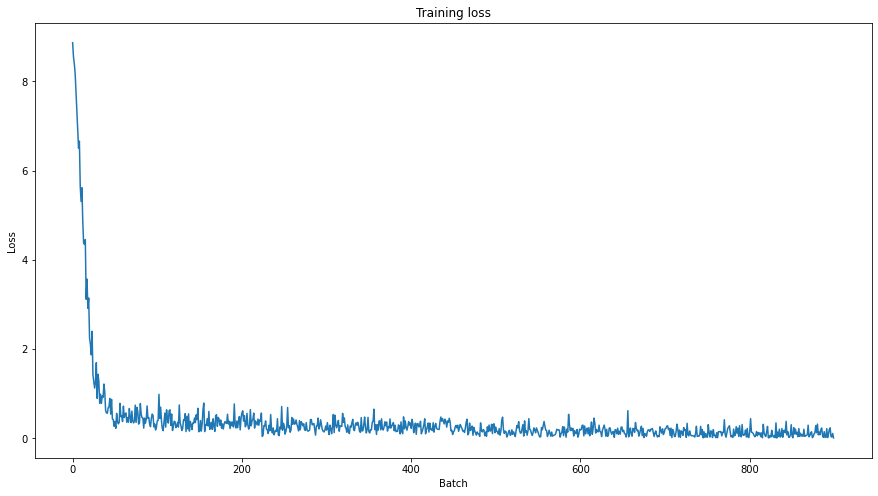

In [21]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

Test model on testing data.

In [22]:
DATA_NAME = "EBA1415-CoralBleaching-little-sentences.tsv"

df_test = pd.read_csv(DATA_PATH + DATA_NAME, delimiter='\t', header=None, names=['essay', 'relation', 's_num', 'sentence'])

df_test.head(50)

,essay,relation,s_num,sentence
0,EBA1415_TFBM_2_CB_ES-05548,O,1.0,No essay //
1,EBA1415_TRJA_11_CB_ES-06110,O,2.0,Somethings that lead to the differences are.. ...
2,EBA1415_TRJA_11_CB_ES-06110,O,3.0,Some have been bleach all white it is a phenom...
3,EBA1415_TRJA_11_CB_ES-06110,O,4.0,Coral bleaching is most noticeable in the Paci...
4,EBA1415_TRJA_11_CB_ES-06110,O,5.0,That ocean covers about 1/3 of the surface of ...
5,EBA1415_TRJA_11_CB_ES-06110,O,6.0,The invertebrate animals live together in Colo...
6,EBA1415_TRJA_11_CB_ES-06110,R-7-50,7.0,The different type of algae living within the ...
7,EBA1415_RHSG_2_CB_ES-05081,R-1-50,8.0,There are several things that cause coral blea...
8,EBA1415_RHSG_2_CB_ES-05081,O,9.0,The trade winds make sea water rise.
9,EBA1415_RHSG_2_CB_ES-05081,R-1-3,10.0,The trade winds also change water temperature


Convert testing data labels to ternary.

In [23]:
relations_test_pd = df_test.relation.copy(deep=True)
df_ternary_test = df_test.copy(deep=True)

for i, rel in relations_test_pd.items():
  chain = rel.split("-")

  if chain[0] == "O":
    relations_test_pd.at[i] = 0
    continue
  
  chain = chain[1] + "," + chain[2]

  if chain in relations:
    relations_test_pd.at[i] = 1
  else: 
    relations_test_pd.at[i] = 2

df_ternary_test.relation = relations_test_pd
df_ternary_test.head(50)

,essay,relation,s_num,sentence
0,EBA1415_TFBM_2_CB_ES-05548,0,1.0,No essay //
1,EBA1415_TRJA_11_CB_ES-06110,0,2.0,Somethings that lead to the differences are.. ...
2,EBA1415_TRJA_11_CB_ES-06110,0,3.0,Some have been bleach all white it is a phenom...
3,EBA1415_TRJA_11_CB_ES-06110,0,4.0,Coral bleaching is most noticeable in the Paci...
4,EBA1415_TRJA_11_CB_ES-06110,0,5.0,That ocean covers about 1/3 of the surface of ...
5,EBA1415_TRJA_11_CB_ES-06110,0,6.0,The invertebrate animals live together in Colo...
6,EBA1415_TRJA_11_CB_ES-06110,1,7.0,The different type of algae living within the ...
7,EBA1415_RHSG_2_CB_ES-05081,1,8.0,There are several things that cause coral blea...
8,EBA1415_RHSG_2_CB_ES-05081,0,9.0,The trade winds make sea water rise.
9,EBA1415_RHSG_2_CB_ES-05081,1,10.0,The trade winds also change water temperature


Identify duplicates in test set.


In [24]:
df_duplicate_sentences_test = df_ternary_test[df_ternary_test.s_num.astype(str).str.split('.', expand=True)[1] != '0']
df_duplicate_sentences_test.head(25)

,essay,relation,s_num,sentence
20,EBA1415_KYNS_4_CB_ES-05390,1,21.1,Weaker trade winds cause higher water temperat...
21,EBA1415_KYNS_4_CB_ES-05390,1,21.2,Weaker trade winds cause higher water temperat...
29,EBA1415_KYNS_4_CB_ES-05390,1,29.1,When the water temperature is constantly chang...
30,EBA1415_KYNS_4_CB_ES-05390,1,29.2,When the water temperature is constantly chang...
31,EBA1415_KYNS_4_CB_ES-05390,1,30.1,Coral bleaching happens when the coral is unhe...
32,EBA1415_KYNS_4_CB_ES-05390,1,30.2,Coral bleaching happens when the coral is unhe...
33,EBA1415_KYNS_4_CB_ES-05390,1,31.1,Trade winds affect the balance of water temper...
34,EBA1415_KYNS_4_CB_ES-05390,1,31.2,Trade winds affect the balance of water temper...
37,EBA1415_KYNS_4_CB_ES-05390,2,34.1,"When the zooxanthellae dies or is ejected, the..."
38,EBA1415_KYNS_4_CB_ES-05390,1,34.2,"When the zooxanthellae dies or is ejected, the..."


Remove duplicates from test set.

In [25]:
current = -1

same_arr_inds = []
drop_list = []

for i, row in df_duplicate_sentences_test.iterrows():
  s_num = str(df_duplicate_sentences_test.loc[i].s_num)
  first_num, second_num = s_num.split(".")

  if first_num != current:
    current = first_num

    if len(same_arr_inds) > 1:

      valid_flag = False
      invalid_flag = False

      for n in same_arr_inds:

        if df_duplicate_sentences_test.loc[n].relation == 1:
          valid_flag = True
          break

        if df_duplicate_sentences_test.loc[n].relation == -1:
          invalid_flag = True 

      left = same_arr_inds[0]
      right = same_arr_inds[1:]

      if valid_flag == True:
        df_duplicate_sentences_test.loc[left].relation = 1
      elif invalid_flag == True:
        df_duplicate_sentences_test.loc[left].relation = -1
      else:
        df_duplicate_sentences_test.loc[left].relation = 0

      drop_list += right   

    same_arr_inds = []
  same_arr_inds.append(i)

df_ternary_test.drop(drop_list, inplace=True)   

df_ternary_test.head(25)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,essay,relation,s_num,sentence
0,EBA1415_TFBM_2_CB_ES-05548,0,1.0,No essay //
1,EBA1415_TRJA_11_CB_ES-06110,0,2.0,Somethings that lead to the differences are.. ...
2,EBA1415_TRJA_11_CB_ES-06110,0,3.0,Some have been bleach all white it is a phenom...
3,EBA1415_TRJA_11_CB_ES-06110,0,4.0,Coral bleaching is most noticeable in the Paci...
4,EBA1415_TRJA_11_CB_ES-06110,0,5.0,That ocean covers about 1/3 of the surface of ...
5,EBA1415_TRJA_11_CB_ES-06110,0,6.0,The invertebrate animals live together in Colo...
6,EBA1415_TRJA_11_CB_ES-06110,1,7.0,The different type of algae living within the ...
7,EBA1415_RHSG_2_CB_ES-05081,1,8.0,There are several things that cause coral blea...
8,EBA1415_RHSG_2_CB_ES-05081,0,9.0,The trade winds make sea water rise.
9,EBA1415_RHSG_2_CB_ES-05081,1,10.0,The trade winds also change water temperature


We must grab the original labels to use later for the additional classification step.

In [26]:
inds = df_ternary_test.index.values.tolist()
df_multi_test = df_test.copy(deep=True)
df_multi_test = df_multi_test[df_multi_test.index.isin(inds)]
print("Test size:",len(df_multi_test))
df_multi_test.head(25)

Test size: 2079


,essay,relation,s_num,sentence
0,EBA1415_TFBM_2_CB_ES-05548,O,1.0,No essay //
1,EBA1415_TRJA_11_CB_ES-06110,O,2.0,Somethings that lead to the differences are.. ...
2,EBA1415_TRJA_11_CB_ES-06110,O,3.0,Some have been bleach all white it is a phenom...
3,EBA1415_TRJA_11_CB_ES-06110,O,4.0,Coral bleaching is most noticeable in the Paci...
4,EBA1415_TRJA_11_CB_ES-06110,O,5.0,That ocean covers about 1/3 of the surface of ...
5,EBA1415_TRJA_11_CB_ES-06110,O,6.0,The invertebrate animals live together in Colo...
6,EBA1415_TRJA_11_CB_ES-06110,R-7-50,7.0,The different type of algae living within the ...
7,EBA1415_RHSG_2_CB_ES-05081,R-1-50,8.0,There are several things that cause coral blea...
8,EBA1415_RHSG_2_CB_ES-05081,O,9.0,The trade winds make sea water rise.
9,EBA1415_RHSG_2_CB_ES-05081,R-1-3,10.0,The trade winds also change water temperature


We must reset the indexes so that they match up with the indexes of the test set predictions.

In [27]:
df_multi_test = df_multi_test.reset_index(drop=True)
df_multi_test.head(25)

,essay,relation,s_num,sentence
0,EBA1415_TFBM_2_CB_ES-05548,O,1.0,No essay //
1,EBA1415_TRJA_11_CB_ES-06110,O,2.0,Somethings that lead to the differences are.. ...
2,EBA1415_TRJA_11_CB_ES-06110,O,3.0,Some have been bleach all white it is a phenom...
3,EBA1415_TRJA_11_CB_ES-06110,O,4.0,Coral bleaching is most noticeable in the Paci...
4,EBA1415_TRJA_11_CB_ES-06110,O,5.0,That ocean covers about 1/3 of the surface of ...
5,EBA1415_TRJA_11_CB_ES-06110,O,6.0,The invertebrate animals live together in Colo...
6,EBA1415_TRJA_11_CB_ES-06110,R-7-50,7.0,The different type of algae living within the ...
7,EBA1415_RHSG_2_CB_ES-05081,R-1-50,8.0,There are several things that cause coral blea...
8,EBA1415_RHSG_2_CB_ES-05081,O,9.0,The trade winds make sea water rise.
9,EBA1415_RHSG_2_CB_ES-05081,R-1-3,10.0,The trade winds also change water temperature


Let's take a look at the class breakdown for the test set.

In [28]:
df_ternary_test["relation"].value_counts()

0    1474
1     587
2      18
Name: relation, dtype: int64

# Extract sentences and labels from test data.

In [29]:
sentences_test = df_ternary_test.sentence.values
sentences_test = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_test]

tokenized_texts_test = [tokenizer.tokenize(sentence) for sentence in sentences_test]
labels_test = df_ternary_test.relation.values.astype(int)
labels_test

array([0, 0, 0, ..., 0, 0, 0])

Tokenize test set essays.

In [30]:
input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Set test set attention masks.

In [31]:
attention_masks_test = []

for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask)

Tensorize and load data.

In [32]:
prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels_test)

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=BATCH_SIZE)

Evaluate test set.

In [33]:
model.eval()

predictions_test, true_labels_test = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits_test = logits.detach().cpu().numpy()
  label_ids_test = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions_test.append(logits_test)
  true_labels_test.append(label_ids_test)

Print confusion matrix.

In [34]:
from sklearn.metrics import confusion_matrix

flat_predictions_test = [item for sublist in predictions_test for item in sublist]
flat_predictions_test = np.argmax(flat_predictions_test, axis=1).flatten()
flat_true_labels_test = [item for sublist in true_labels_test for item in sublist]

y_pred = flat_predictions_test
y = flat_true_labels_test

stats = confusion_matrix(y, y_pred).ravel()

print("\t\t\t      Predicted\n")
print("\t\t\tNone\tValid\tInvalid")
print("\n\t\tNone\t{}     {}        {}".format(stats[0], stats[1], stats[2]))
print("      Actual")
print("\t\tValid\t{}      {}        {}".format(stats[3], stats[4], stats[5]))
print("\n\t\tInvalid\t {}       {}        {}".format(stats[6], stats[7], stats[8]))

			      Predicted

			None	Valid	Invalid

		None	1353     121        0
      Actual
		Valid	115      472        0

		Invalid	 7       11        0


Now we must isolate the predictions. We will start with the negative class.

In [35]:
test_pred_norelation_inds = [i for i in range(len(y_pred)) if y_pred[i] == 0]
test_pred_norelation_arr = [y_pred[i] for i in test_pred_norelation_inds]
print("Predicted no relation:",len(test_pred_norelation_inds))

Predicted no relation: 1475


Isolate corresponding actual labels.

In [36]:
test_true_norelation_inds = [i for i in range(len(y)) if y[i] == 0]
test_true_norelation_arr = [y[i] for i in test_pred_norelation_inds]
print("Actual no relation:",len(test_true_norelation_inds))

Actual no relation: 1474


Let's take a look at the stats for just the negative class.

In [37]:
test_pred_norelation_all_inds = [i for i in range(len(y_pred)) if y_pred[i] == 0 or  y[i] == 0]
test_pred_norelation_all_arr = [y_pred[i] for i in test_pred_norelation_all_inds]
test_true_norelation_all_arr = [y[i] for i in test_pred_norelation_all_inds]

neg_stats = confusion_matrix(test_true_norelation_all_arr, test_pred_norelation_all_arr).ravel()

print("\t\t\t      Predicted\n")
print("\t\t\tNone\tValid\tInvalid")
print("\n\t\tNone\t{}     {}        {}".format(neg_stats[0], neg_stats[1], neg_stats[2]))
print("      Actual")
print("\t\tValid\t{}      {}        {}".format(neg_stats[3], neg_stats[4], neg_stats[5]))
print("\n\t\tInvalid\t {}       {}        {}".format(neg_stats[6], neg_stats[7], neg_stats[8]))

			      Predicted

			None	Valid	Invalid

		None	1353     121        0
      Actual
		Valid	115      0        0

		Invalid	 7       0        0


Get precision, recall, and F1 for negative class.

In [38]:
neg_prec = neg_stats[0] / (neg_stats[0] + neg_stats[3] + neg_stats[6])
neg_rec = neg_stats[0] / (neg_stats[0] + neg_stats[1] + neg_stats[2])
neg_f1 = 2*neg_prec*neg_rec / (neg_prec + neg_rec)

print("Negative class metrics:\n")
print("Precision: ",neg_prec)
print("Recall:    ",neg_rec)
print("F1:        ",neg_f1)

Negative class metrics:

Precision:  0.9172881355932203
Recall:     0.917910447761194
F1:         0.9175991861648016


Get negative accuracy

In [39]:
num_neg_predict = 0
neg_correct = 0
neg_incorrect = 0

for i in range(len(y)):
  if y_pred[i] == 0:
    num_neg_predict += 1
    if y[i] == 0:
      neg_correct += 1
    else: 
      neg_incorrect += 1

print("Total predicted negative:",num_neg_predict)
print("Negatives predicted correctly:", neg_correct)
print("Negatives predicted incorrectly:", neg_incorrect)
print("Negative accuracy:", neg_correct/num_neg_predict)

Total predicted negative: 1475
Negatives predicted correctly: 1353
Negatives predicted incorrectly: 122
Negative accuracy: 0.9172881355932203


Now we must isolate the valid and invalid predictions so that we can run them through the multilabel classifier.

In [40]:
# Get array of all instances predicted valid

test_pred_valid_inds = [i for i in range(len(y_pred)) if y_pred[i] == 1]
test_true_valid_inds = [i for i in range(len(y)) if y[i] == 1]
print("Predicted valid:",len(test_pred_valid_inds))
print("Actual valid:",len(test_true_valid_inds))

Predicted valid: 604
Actual valid: 587


In [41]:
# Get array of all instances predicted invalid

test_pred_invalid_inds = [i for i in range(len(y_pred)) if y_pred[i] == 2]
test_true_invalid_inds = [i for i in range(len(y)) if y[i] == 2]
print("Predicted invalid:",len(test_pred_invalid_inds))
print("Actual invalid:",len(test_true_invalid_inds))

Predicted invalid: 0
Actual invalid: 18


In [42]:
# Create dataframe of valid predictions

df_multi_test_valid = df_multi_test.copy(deep=True)
df_multi_test_valid = df_multi_test_valid[df_multi_test_valid.index.isin(test_pred_valid_inds)]
print("Test size (valid predictions):",len(df_multi_test_valid))
df_multi_test_valid.head(25)

Test size (valid predictions): 604


,essay,relation,s_num,sentence
6,EBA1415_TRJA_11_CB_ES-06110,R-7-50,7.0,The different type of algae living within the ...
7,EBA1415_RHSG_2_CB_ES-05081,R-1-50,8.0,There are several things that cause coral blea...
9,EBA1415_RHSG_2_CB_ES-05081,R-1-3,10.0,The trade winds also change water temperature
15,EBA1415_KYNS_4_CB_ES-05390,R-1-50,16.0,What lead to differences in the rates of coral...
17,EBA1415_KYNS_4_CB_ES-05390,O,18.0,One cause is shifting trade winds.
18,EBA1415_KYNS_4_CB_ES-05390,R-1-2,19.0,"Trade winds travel from east to west, causing ..."
19,EBA1415_KYNS_4_CB_ES-05390,O,20.0,"Tradewinds constantly shift, causing major cha..."
20,EBA1415_KYNS_4_CB_ES-05390,R-1-3,21.1,Weaker trade winds cause higher water temperat...
26,EBA1415_KYNS_4_CB_ES-05390,R-3-5,27.0,"In order for coral to survive, it needs water ..."
27,EBA1415_KYNS_4_CB_ES-05390,R-3-4,28.0,"When water temperature increases, the amount o..."


In [43]:
# Going to edit iteratively (lazily)...will fix later.

for i, row in df_multi_test_valid.iterrows():
  r = row.relation

  if r == 'O': continue
  r_split = r.split("-")
  r = r_split[1] + "," + r_split[2]
  df_multi_test_valid.at[i, "relation"] = r
  
df_multi_test_valid.head()

,essay,relation,s_num,sentence
6,EBA1415_TRJA_11_CB_ES-06110,"7,50",7.0,The different type of algae living within the ...
7,EBA1415_RHSG_2_CB_ES-05081,"1,50",8.0,There are several things that cause coral blea...
9,EBA1415_RHSG_2_CB_ES-05081,"1,3",10.0,The trade winds also change water temperature
15,EBA1415_KYNS_4_CB_ES-05390,"1,50",16.0,What lead to differences in the rates of coral...
17,EBA1415_KYNS_4_CB_ES-05390,O,18.0,One cause is shifting trade winds.


In [44]:
# Create dataframe of invalid predictions

df_multi_test_invalid = df_multi_test.copy(deep=True)
df_multi_test_invalid = df_multi_test_invalid[df_multi_test_invalid.index.isin(test_pred_invalid_inds)]
print("Test size (invalid predictions):",len(df_multi_test_invalid))
df_multi_test_invalid.head(25)

Test size (invalid predictions): 0


,essay,relation,s_num,sentence


In [45]:
# Going to edit iteratively (lazily)...will fix later.

for i, row in df_multi_test_invalid.iterrows():
  r = row.relation

  if r == 'O': continue
  r_split = r.split("-")
  r = r_split[1] + "," + r_split[2]
  df_multi_test_invalid.at[i, "relation"] = r
  
df_multi_test_invalid.head()

,essay,relation,s_num,sentence


Now we will fine-tune a BERT model just for the valid relations.

In [46]:
# First must edit relations 

df_valid = df.copy(deep=True)

# Going to edit iteratively (lazily)...will fix later.

for i, row in df_valid.iterrows():
  r = row.relation

  if r == 'O': continue
  r_split = r.split("-")
  r = r_split[1] + "," + r_split[2]
  df_valid.at[i, "relation"] = r
  
df_valid.head()

,essay,relation,s_num,sentence
0,EBA1415_KNKC_1_CB_ES-05410,O,1.0,Coral and zooxanthellae depend an each other i...
1,EBA1415_KNKC_1_CB_ES-05410,"7,50",2.0,"If the coral dies, or gets bleached, then the ..."
2,EBA1415_KNKC_1_CB_ES-05410,O,3.0,Or the other way around.
3,EBA1415_KNKC_1_CB_ES-05410,O,4.0,"In the text Shifting Trade Winds, it talks abo..."
4,EBA1415_KNKC_1_CB_ES-05410,"3,1",5.0,And another source states how when the water t...


In [47]:
# Now isolate the valid ones

df_valid = df_valid[df_valid['relation'].isin(relations)]
df_valid.head()

,essay,relation,s_num,sentence
1,EBA1415_KNKC_1_CB_ES-05410,"7,50",2.0,"If the coral dies, or gets bleached, then the ..."
8,EBA1415_KNKC_1_CB_ES-05410,"5B,50",9.1,Which can affect the coral because if the zoox...
10,EBA1415_KNKC_1_CB_ES-05410,"1,50",10.0,So shifitng trade is what leads to the differe...
19,EBA1415post_WSKT_1_CB_ES-05486,"3,50",19.0,Coral bleaching can be led to by the rise of w...
22,EBA1415post_WSKT_1_CB_ES-05486,"3,4",22.0,"When this occurs, it makes it harder for coral..."


In [48]:
# Create sentence and label lists
sentences = df_valid.sentence.values

# Add special tokens at the beginning and end of each sentence to comply with BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df_valid.relation.values

In [49]:
# Now that our [CLS] and [SEP] tokens are in place, we are ready for tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("First sentence tokenized: ",tokenized_texts[0])

First sentence tokenized:  ['[CLS]', 'if', 'the', 'coral', 'dies', ',', 'or', 'gets', 'b', '##lea', '##ched', ',', 'then', 'the', 'zoo', '##xa', '##nt', '##hell', '##ae', 'dies', '.', '[SEP]']


In [50]:
'''
For each tokenized input sentence, we need to create:

1. input ids:
    a sequence of integers identifying each input token to its index number 
    in the BERT tokenizer vocabulary

2. segment mask: (optional) a sequence of 1s and 0s used to identify whether the input is one 
    sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. 
    For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 
    1 for each token of the second sentence

3. attention mask: (optional) 
    a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens 

4. labels: based on the labels from the data set
'''

# For now, we will simply delete the tokenized_texts greater than MAX_LEN.

# We need to strip out the sentences greater than MAX_LEN tokens
original_length = len(tokenized_texts)

labels = [labels[i] for i in range(len(tokenized_texts)) if len(tokenized_texts[i]) <= MAX_LEN]
tokenized_texts = [tokenized_texts[i] for i in range(len(tokenized_texts)) if len(tokenized_texts[i]) <= MAX_LEN]
print("Removed {0} sentences greater than {1}".format(original_length - len(tokenized_texts),MAX_LEN))

Removed 3 sentences greater than 128


In [51]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [52]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [53]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [54]:
# Now map each label to its corresponding integer
print("Old labels: ",str(labels))
labels = [relations.index(l) for l in labels]
print("New labels: ",str(labels))

Old labels:  ['7,50', '5B,50', '1,50', '3,50', '3,4', '4,5', '5,5B', '5,5B', '4,50', '2,3', '3,50', '3,50', '13,50', '3,7', '3,50', '1,50', '1,3', '3,50', '3,50', '1,3', '13,50', '11,50', '11,12', '12,14', '1,50', '3,50', '3,50', '6,7', '6,7', '7,50', '1,2', '2,50', '3,5', '3,4', '4,14', '7,50', '6,7', '6,7', '7,50', '6,7', '7,50', '6,7', '7,50', '7,50', '7,50', '7,50', '7,50', '7,50', '6,50', '6,7', '6,7', '1,50', '5,50', '7,50', '1,3', '1,3', '3,50', '7,50', '1,7', '5B,50', '5B,50', '1,50', '1,3', '1,2', '3,5', '11,13', '14,50', '7,50', '1,2', '1,2', '6,7', '3,50', '1,50', '4,14', '4,14', '7,50', '1,2', '2,3', '3,50', '11,13', '12,50', '13,50', '6,7', '1,50', '1,2', '7,50', '7,50', '1,3', '5,5B', '6,7', '7,50', '5B,50', '11,12', '12,13', '13,14', '13,14', '3,50', '4,50', '3,5', '5,5B', '4,5', '6,7', '7,50', '3,50', '4,50', '7,50', '5,7', '3,7', '1,7', '1,3', '3,50', '1,3', '2,3', '11,50', '11,12', '12,13', '13,14', '14,50', '14,50', '1,3', '1,2', '1,2', '3,5', '3,4', '4,5', '5,7', '7

In [55]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [56]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [57]:
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

In [58]:
# This is where the fine-tuning comes in. We must train the model for our specific task.

# We will first modify pre-trained BERT for our specific task, then continue training on our data until the entire model
#   is well-suited for our task.

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels))
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [59]:
'''
Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4
'''

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [60]:
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=LEARNING_RATE,
                     warmup=WARMUP)

t_total value of -1 results in schedule not being applied


In [61]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(EPOCHS, desc="Epoch"):
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 4.005575799129226


Epoch:  25%|██▌       | 1/4 [00:29<01:28, 29.36s/it]

Validation Accuracy: 0.4829545454545454
Train loss: 1.8808576193722812


Epoch:  50%|█████     | 2/4 [00:58<00:58, 29.34s/it]

Validation Accuracy: 0.5761363636363637
Train loss: 1.4740522280335426


Epoch:  75%|███████▌  | 3/4 [01:27<00:29, 29.28s/it]

Validation Accuracy: 0.5835227272727272
Train loss: 1.2482025101780891


Epoch: 100%|██████████| 4/4 [01:57<00:00, 29.27s/it]

Validation Accuracy: 0.5852272727272727


Now we will evaluate the instances guessed valid with the valid-trained BERT.

In [62]:
sentences_test_valid = df_multi_test_valid.sentence.values
sentences_test_valid = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_test_valid]

tokenized_texts_test_valid = [tokenizer.tokenize(sentence) for sentence in sentences_test_valid]
labels_test_valid = df_multi_test_valid.relation.values
labels_test_valid[:50]

array(['7,50', '1,50', '1,3', '1,50', 'O', '1,2', 'O', '1,3', '3,5',
       '3,4', '3,14', '14,50', '1,3', '7,14', 'O', '3,5', '7,50', '7,50',
       '6,50', '6,5', '6,50', '3,4', '4,14', 'O', '3,50', '3,50', '13,14',
       '4,5B', 'O', '1,50', '1,50', '6,7', '1,3', '7,50', '6,50', '6,7',
       '6,7', '7,50', 'O', '14,50', '3,4', '4,14', 'O', '7,50', '3,50',
       '1,50', '3,50', '3,50', '3,4', '4,50'], dtype=object)

In [63]:
# Now map each label to its corresponding integer
print("Old labels: ",str(labels_test_valid[:50]))
labels_test_valid = [relations.index(l) if l in relations else 999 for l in labels_test_valid]
print("New labels: ",str(labels_test_valid))

Old labels:  ['7,50' '1,50' '1,3' '1,50' 'O' '1,2' 'O' '1,3' '3,5' '3,4' '3,14' '14,50'
 '1,3' '7,14' 'O' '3,5' '7,50' '7,50' '6,50' '6,5' '6,50' '3,4' '4,14' 'O'
 '3,50' '3,50' '13,14' '4,5B' 'O' '1,50' '1,50' '6,7' '1,3' '7,50' '6,50'
 '6,7' '6,7' '7,50' 'O' '14,50' '3,4' '4,14' 'O' '7,50' '3,50' '1,50'
 '3,50' '3,50' '3,4' '4,50']
New labels:  [59, 8, 1, 8, 999, 0, 999, 1, 18, 17, 20, 56, 1, 999, 999, 18, 59, 59, 58, 999, 58, 17, 26, 999, 23, 23, 50, 25, 999, 8, 8, 57, 1, 59, 58, 57, 57, 59, 999, 56, 17, 26, 999, 59, 23, 8, 23, 23, 17, 29, 8, 8, 1, 999, 999, 18, 57, 39, 17, 8, 1, 8, 999, 23, 44, 39, 17, 999, 33, 24, 24, 999, 999, 59, 59, 24, 999, 23, 1, 999, 23, 8, 17, 26, 40, 50, 59, 23, 23, 23, 8, 8, 1, 38, 59, 1, 999, 40, 44, 59, 24, 24, 999, 9, 8, 23, 8, 999, 23, 18, 17, 17, 17, 8, 999, 8, 1, 53, 30, 999, 8, 23, 53, 59, 59, 59, 999, 24, 50, 1, 17, 23, 1, 8, 59, 0, 999, 999, 17, 29, 25, 57, 17, 26, 0, 999, 999, 24, 999, 999, 999, 59, 59, 999, 999, 59, 29, 18, 40, 29, 999, 8, 17, 

In [64]:
input_ids_test_valid = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test_valid]
input_ids_test_valid = pad_sequences(input_ids_test_valid, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [65]:
attention_masks_test_valid = []

for seq in input_ids_test_valid:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test_valid.append(seq_mask)

In [66]:
prediction_inputs_valid = torch.tensor(input_ids_test_valid)
prediction_masks_valid = torch.tensor(attention_masks_test_valid)
prediction_labels_valid = torch.tensor(labels_test_valid)

prediction_data_valid = TensorDataset(prediction_inputs_valid, prediction_masks_valid, prediction_labels_valid)
prediction_sampler_valid = SequentialSampler(prediction_data_valid)
prediction_dataloader_valid = DataLoader(prediction_data_valid, sampler=prediction_sampler_valid, batch_size=BATCH_SIZE)

In [67]:
model.eval()

predictions_test_valid, true_labels_test_valid = [], []

# Predict 
for batch in prediction_dataloader_valid:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits_test = logits.detach().cpu().numpy()
  label_ids_test = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions_test_valid.append(logits_test)
  true_labels_test_valid.append(label_ids_test)

In [68]:
flat_predictions_test_valid = [item for sublist in predictions_test_valid for item in sublist]
flat_predictions_test_valid = np.argmax(flat_predictions_test_valid, axis=1).flatten()
flat_true_labels_test_valid = [item for sublist in true_labels_test_valid for item in sublist]

y_pred_valid = flat_predictions_test_valid
y_valid = flat_true_labels_test_valid

print(y_pred_valid)
print(y_valid)

[59  8  1  8  8  0  0 23 18 17  1 59 59 59  8 18 59 59 58 30 59 17 26 56
 23 23 50 18 23  8  8 59 59 59 58 57 57 59  0 56 17 26 58 59 23  8 23 23
 17 23  8  8 17 17 50 18 57 45 17  8  1  8  1 53 44 45 24 24 34 24 24 30
 59 59 59 24 59 23  1 50 23 53 17 26 40 50 59 23 23 23  8  8  1 59 59 23
 59 40 44 59 24 24 53  9  8 23  8  8 23 18 23 26 17 44 40 23 23 23 34 59
 23 23 53 59 59 59 59 24 50 23 17 23  1  1 59 23  8  1 17 24 26 59 17 26
  0 41  1 24 18 26 41 59 59 59 59 59 29 18 40 24 17  9 17  8 17 26 56  8
  9 17 26 57 59 59  8  8 30 30 56 57 18  8  1 18 50 45 18 40 59 18 50 45
 29 44 44 45 50  9  8 40 50 18 18 59  8  0 24  8 23 57 57 18 23 23  1 53
 50 24 59 23 45 24 30 53 18 17 30 23 23 23 18 17 26 41 58 57  8  1 23 23
  8  1 23 59 59 23 57 59  9 59 26 23 45 30 59 56 59 23 18  1  8 53 40 30
 23  9 18  1 23 44 44 44 59 57 59 18 59 59 40 23 23  8  0  8 23  8 59  1
 45 40 45 50 50 23 59 17 23 45  0  1  8  8 23  8  9 18 30 59 23 59 17 26
 59  8 23  8  9 17 26 40 50 57 59 23 59 56  1 23  1

Extract stats.

In [69]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred_valid))

              precision    recall  f1-score   support

           0       0.75      0.94      0.83        16
           1       0.64      0.60      0.62        45
           3       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.75      0.71      0.73        63
           9       0.50      1.00      0.67         5
          16       0.00      0.00      0.00         1
          17       0.76      0.69      0.72        36
          18       0.60      0.90      0.72        20
          20       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         2
          22       0.00      0.00      0.00         2
          23       0.46      0.86      0.60        43
          24       0.55      1.00      0.71        12
          25       0.00      0.00      0.00         3
          26       0.55      1.00      0.71        11
          29       0.64    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Extract accuracy of valid relations.

In [70]:
p = 0
n = 0
for i in range(len(y_pred_valid)):
  if y_pred_valid[i] == y_valid[i]:
    p += 1
  else:
    n += 1

print("Valid guessed correctly:",p)
print("Valid guessed incorrectly:",n)
print("Total valid:", p + n)
print("Valid accuracy:", p/(p+n))

Valid guessed correctly: 355
Valid guessed incorrectly: 249
Total valid: 604
Valid accuracy: 0.5877483443708609


Let's recap with the negative and valid classes.

In [71]:
print("Negatives predicted correctly:", neg_correct)
print("Negatives predicted incorrectly:", neg_incorrect)
print("Total predicted negative:",num_neg_predict)
print("Negative accuracy:", neg_correct/num_neg_predict)

Negatives predicted correctly: 1353
Negatives predicted incorrectly: 122
Total predicted negative: 1475
Negative accuracy: 0.9172881355932203


In [72]:
# Total accuracy with valid and no relation

print((neg_correct+p)/(num_neg_predict+p+n))

0.8215488215488216


Now for the invalid relations.

In [73]:
# First must edit relations 

df_valid = df.copy(deep=True)

# Going to edit iteratively (lazily)...will fix later.

for i, row in df_valid.iterrows():
  r = row.relation

  if r == 'O': continue
  r_split = r.split("-")
  r = r_split[1] + "," + r_split[2]
  df_valid.at[i, "relation"] = r
  
df_valid.head()

,essay,relation,s_num,sentence
0,EBA1415_KNKC_1_CB_ES-05410,O,1.0,Coral and zooxanthellae depend an each other i...
1,EBA1415_KNKC_1_CB_ES-05410,"7,50",2.0,"If the coral dies, or gets bleached, then the ..."
2,EBA1415_KNKC_1_CB_ES-05410,O,3.0,Or the other way around.
3,EBA1415_KNKC_1_CB_ES-05410,O,4.0,"In the text Shifting Trade Winds, it talks abo..."
4,EBA1415_KNKC_1_CB_ES-05410,"3,1",5.0,And another source states how when the water t...


In [74]:
# Now isolate the valid ones

df_valid = df_valid[~df_valid['relation'].isin(relations)]
df_valid = df_valid[df_valid['relation'] != "O"]
df_valid.head(25)

,essay,relation,s_num,sentence
4,EBA1415_KNKC_1_CB_ES-05410,"3,1",5.0,And another source states how when the water t...
9,EBA1415_KNKC_1_CB_ES-05410,"50,7",9.2,Which can affect the coral because if the zoox...
20,EBA1415post_WSKT_1_CB_ES-05486,"3,1",20.0,"According to the graph ""Trade Winds + coral Bl..."
178,EBA1415_TRJA_11_CB_ES-06102,"3,1",163.0,When the water is at a cold degrees like in th...
179,EBA1415_TRJA_11_CB_ES-06102,"3,2",164.0,If the water is at a near cold degrees like in...
198,EBA1415post_TWNB_2_CB_ES-04975,"6,14",182.2,Coral bleaching is one example of how environm...
465,EBA1415_SDMK_7_CB_ES-04782,"3,1",427.1,In the chart it shows that because the water t...
474,EBA1415_SDMK_7_CB_ES-04782,"6,14",434.2,Coral bleaching is one example of how environm...
601,EBA1415_TWMD_45_CB_ES-04996,"4,3",547.0,"But when the amount of CO2 decreases, it effec..."
602,EBA1415_TWMD_45_CB_ES-04996,"4,3",548.0,It also threatens the corals balance of water ...


In [75]:
# Create sentence and label lists
sentences = df_valid.sentence.values

# Add special tokens at the beginning and end of each sentence to comply with BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df_valid.relation.values

In [76]:
# Now that our [CLS] and [SEP] tokens are in place, we are ready for tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("First sentence tokenized: ",tokenized_texts[0])

First sentence tokenized:  ['[CLS]', 'and', 'another', 'source', 'states', 'how', 'when', 'the', 'water', 'temperature', 'rises', ',', 'the', 'trade', 'winds', 'weaken', '.', '[SEP]']


In [77]:
'''
For each tokenized input sentence, we need to create:

1. input ids:
    a sequence of integers identifying each input token to its index number 
    in the BERT tokenizer vocabulary

2. segment mask: (optional) a sequence of 1s and 0s used to identify whether the input is one 
    sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. 
    For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 
    1 for each token of the second sentence

3. attention mask: (optional) 
    a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens 

4. labels: based on the labels from the data set
'''

# For now, we will simply delete the tokenized_texts greater than MAX_LEN.

# We need to strip out the sentences greater than MAX_LEN tokens
original_length = len(tokenized_texts)

labels = [labels[i] for i in range(len(tokenized_texts)) if len(tokenized_texts[i]) <= MAX_LEN]
tokenized_texts = [tokenized_texts[i] for i in range(len(tokenized_texts)) if len(tokenized_texts[i]) <= MAX_LEN]
print("Removed {0} sentences greater than {1}".format(original_length - len(tokenized_texts),MAX_LEN))

Removed 3 sentences greater than 128


In [78]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [79]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [80]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [81]:
# At this point we must convert our labels from strings to ints (required for tensorization)

# First we are going to create an array of all possible labels
label_types_invalid = {}
for i in range(len(labels)):
  if labels[i] not in label_types_invalid:
    label_types_invalid.update({labels[i] : len(label_types_invalid)})
print("Total labels_types: {0}\nLabels: {1}".format(len(label_types_invalid),str(label_types_invalid)))

Total labels_types: 38
Labels: {'3,1': 0, '50,7': 1, '3,2': 2, '6,14': 3, '4,3': 4, '11,3': 5, '50,50': 6, '7,13': 7, '7,1': 8, '4,13': 9, '7,14': 10, '50,1': 11, '14,11': 12, '7,5B': 13, '50,3': 14, '11,11': 15, '12,11': 16, '13,11': 17, '12,5B': 18, '5,4': 19, 'OTHER,13': 20, '11,OTHER': 21, '3,13': 22, '13,12': 23, '1,11': 24, '7,5': 25, '1,13': 26, '5,13': 27, '5B,5': 28, '11,1': 29, '5,3': 30, '4,11': 31, '11,4': 32, '2,1': 33, '6,5B': 34, '13,4': 35, '7,6': 36, '13,5': 37}


In [82]:
# Now map each label to its corresponding integer
print("Old labels: ",str(labels))
labels = [label_types_invalid[l] if l in label_types_invalid else 999 for l in labels]
print("New labels: ",str(labels))

Old labels:  ['3,1', '50,7', '3,1', '3,1', '3,2', '6,14', '3,1', '6,14', '4,3', '4,3', '6,14', '6,14', '11,3', '50,50', '3,1', '7,13', '7,1', '3,1', '4,13', '4,13', '7,14', '7,14', '7,14', '6,14', '6,14', '50,50', '50,1', '3,1', '6,14', '50,50', '50,7', '14,11', '14,11', '6,14', '6,14', '7,5B', '7,5B', '6,14', '50,3', '4,3', '11,11', '12,11', '13,11', '6,14', '3,1', '3,1', '12,5B', '5,4', '13,11', '13,11', 'OTHER,13', '11,OTHER', '11,OTHER', 'OTHER,13', '7,5B', '6,14', '50,3', '50,3', '3,13', '13,12', '1,11', '7,14', '7,5', '6,14', '6,14', '11,3', '6,14', '7,5B', '1,13', '5,13', '6,14', '6,14', '6,14', '6,14', '4,3', '3,1', '5B,5', '6,14', '5B,5', '6,14', '6,14', '6,14', '3,1', '6,14', '3,1', '3,1', '7,5B', '50,7', '50,7', '50,1', '4,13', '6,14', '11,1', '11,1', '11,3', '6,14', '6,14', '3,13', '3,13', '6,14', '3,13', '6,14', '6,14', '6,14', '6,14', '6,14', '5,3', '6,14', '6,14', '6,14', '7,5B', '50,1', '5B,5', '6,14', '11,3', '13,12', '6,14', '6,14', '4,11', '11,4', '2,1', '6,5B', '13,

In [83]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [84]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [85]:
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

In [86]:
# This is where the fine-tuning comes in. We must train the model for our specific task.

# We will first modify pre-trained BERT for our specific task, then continue training on our data until the entire model
#   is well-suited for our task.

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels))
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [87]:
'''
Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4
'''

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [88]:
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=LEARNING_RATE,
                     warmup=WARMUP)

t_total value of -1 results in schedule not being applied


In [89]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(EPOCHS, desc="Epoch"):
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:  25%|██▌       | 1/4 [00:01<00:04,  1.39s/it]

Train loss: 4.87184476852417
Validation Accuracy: 0.4


Epoch:  50%|█████     | 2/4 [00:02<00:02,  1.37s/it]

Train loss: 4.330363869667053
Validation Accuracy: 0.4


Epoch:  75%|███████▌  | 3/4 [00:04<00:01,  1.35s/it]

Train loss: 3.6736958622932434
Validation Accuracy: 0.4


Epoch: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

Train loss: 3.0916221141815186
Validation Accuracy: 0.4666666666666667


In [90]:
sentences_test_valid = df_multi_test_invalid.sentence.values
sentences_test_valid = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_test_valid]

tokenized_texts_test_valid = [tokenizer.tokenize(sentence) for sentence in sentences_test_valid]
labels_test_valid = df_multi_test_invalid.relation.values
labels_test_valid[:50]

array([], dtype=object)

In [91]:
# Now map each label to its corresponding integer
print("Old labels: ",str(labels_test_valid[:50]))
labels_test_valid = [label_types_invalid[l] if l in label_types_invalid else 999 for l in labels_test_valid]
print("New labels: ",str(labels_test_valid))

Old labels:  []
New labels:  []


In [92]:
input_ids_test_valid = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test_valid]
input_ids_test_valid = pad_sequences(input_ids_test_valid, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [93]:
attention_masks_test_valid = []

for seq in input_ids_test_valid:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test_valid.append(seq_mask)

In [94]:
prediction_inputs_valid = torch.tensor(input_ids_test_valid)
prediction_masks_valid = torch.tensor(attention_masks_test_valid)
prediction_labels_valid = torch.tensor(labels_test_valid)

prediction_data_valid = TensorDataset(prediction_inputs_valid, prediction_masks_valid, prediction_labels_valid)
prediction_sampler_valid = SequentialSampler(prediction_data_valid)
prediction_dataloader_valid = DataLoader(prediction_data_valid, sampler=prediction_sampler_valid, batch_size=BATCH_SIZE)

In [95]:
model.eval()

predictions_test_valid, true_labels_test_valid = [], []

# Predict 
for batch in prediction_dataloader_valid:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits_test = logits.detach().cpu().numpy()
  label_ids_test = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions_test_valid.append(logits_test)
  true_labels_test_valid.append(label_ids_test)

In [96]:
flat_predictions_test_valid = [item for sublist in predictions_test_valid for item in sublist]
if (len(labels_test_valid) > 0): flat_predictions_test_valid = np.argmax(flat_predictions_test_valid, axis=1).flatten()
flat_true_labels_test_valid = [item for sublist in true_labels_test_valid for item in sublist]

y_pred_valid = flat_predictions_test_valid
y_valid = flat_true_labels_test_valid

print(y_pred_valid)
print(y_valid)

[]
[]


In [97]:
from sklearn.metrics import classification_report
if (len(labels_test_valid) > 0): print(classification_report(y_valid, y_pred_valid))

In [98]:
p_i = 0
n_i = 0
for i in range(len(y_pred_valid)):
  if y_pred_valid[i] == y_valid[i]:
    p_i += 1
  else:
    n_i += 1

print("Invalid guessed correctly:",p_i)
print("Invalid guessed incorrectly:",n_i)
print("Total invalid:", p_i + n_i)
if (len(labels_test_valid) > 0): print("Invalid accuracy:", p_i/(p_i+n_i))
else: print("Invalid accuracy:",0)

Invalid guessed correctly: 0
Invalid guessed incorrectly: 0
Total invalid: 0
Invalid accuracy: 0


Let's recap with the negative and valid classes.

In [99]:
print("Negatives predicted correctly:", neg_correct)
print("Negatives predicted incorrectly:", neg_incorrect)
print("Total predicted negative:",num_neg_predict)
print("Negative accuracy:", neg_correct/num_neg_predict)

Negatives predicted correctly: 1353
Negatives predicted incorrectly: 122
Total predicted negative: 1475
Negative accuracy: 0.9172881355932203


In [100]:
print("Valid guessed correctly:",p)
print("Valid guessed incorrectly:",n)
print("Total valid:", p + n)
print("Valid accuracy:", p/(p+n))

Valid guessed correctly: 355
Valid guessed incorrectly: 249
Total valid: 604
Valid accuracy: 0.5877483443708609


Total accuracy

In [101]:
total_preds = num_neg_predict + p + n + p_i + n_i
print("Total guesses:", total_preds)

print("\nCorrect negative guesses:", neg_correct)
print("Incorrect negative guesses:", neg_incorrect)
print("Total negative guesses:", neg_correct + neg_incorrect)
print("Negatige accuracy:", neg_correct/num_neg_predict)

print("\nCorrect valid guesses:", p)
print("Incorrect valid guesses:", n)
print("Total valid guesses:", p + n)
print("Valid accuracy:", p/(p+n))

print("\nCorrect invalid guesses:", p_i)
print("Incorrect invalid guesses:", n_i)
print("Total invalid guesses:", p_i + n_i)
print("Invalid accuracy:", p_i/(p_i+n_i) if p_i+n_i else 0)

print("\nTotal accuracy:", (neg_correct+p+p_i)/total_preds)

Total guesses: 2079

Correct negative guesses: 1353
Incorrect negative guesses: 122
Total negative guesses: 1475
Negatige accuracy: 0.9172881355932203

Correct valid guesses: 355
Incorrect valid guesses: 249
Total valid guesses: 604
Valid accuracy: 0.5877483443708609

Correct invalid guesses: 0
Incorrect invalid guesses: 0
Total invalid guesses: 0
Invalid accuracy: 0

Total accuracy: 0.8215488215488216
